<a href="https://colab.research.google.com/github/Shirav-001/deep-learning/blob/main/neural_familiarity_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Familiarity Classifier  
**Author:** Shiraf Moussa

**Matriculation No.:** 1011541


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from scipy.stats import ks_2samp, entropy
import numpy.fft as fft

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report
)

# Verify imports
print("Libraries imported successfully!")


Libraries imported successfully!


With these imports in place, im ready to tackle:

- Data upload & visualization

- Feature engineering (firing rates, synchrony, FFT, etc.)

- Exploratory distribution analysis

- Model training & comparison

- Performance evaluation

In [ ]:
!ls -l


total 27756
drwx------ 2 root root     4096 Apr 18 08:30 data
-rw-r--r-- 1 root root  5331707 Apr 18 16:19 data.zip
drwxr-xr-x 3 root root     4096 Apr 18 16:20 __MACOSX
drwxr-xr-x 1 root root     4096 Apr 16 13:40 sample_data
-rw-r--r-- 1 root root 23068672 Apr 18 16:27 x.npy
-rw-r--r-- 1 root root     6528 Apr 18 16:26 y.npy


In [ ]:
!unzip data.zip


Archive:  data.zip
   creating: data/
  inflating: __MACOSX/._data         
  inflating: data/x.npy              
  inflating: __MACOSX/data/._x.npy   
  inflating: data/y.npy              
  inflating: __MACOSX/data/._y.npy   


Loaded X from 'data/x.npy' with shape: (800, 1000, 501)
Loaded y from 'data/y.npy' with shape: (800,)


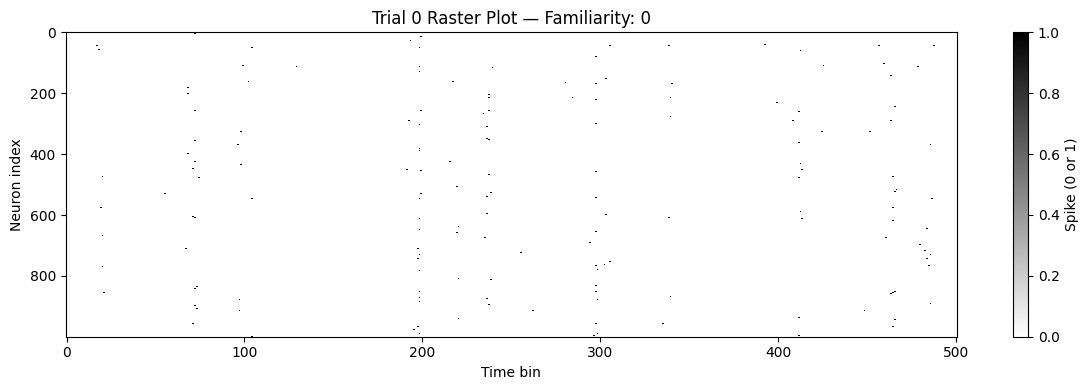

In [ ]:
# 1) Choose the right files from the 'data' folder rather than any corrupted copies
data_folder = 'data'
x_path = os.path.join(data_folder, 'x.npy')
y_path = os.path.join(data_folder, 'y.npy')

if not os.path.exists(x_path) or not os.path.exists(y_path):
    raise FileNotFoundError(f"Ensure 'x.npy' and 'y.npy' exist in the '{data_folder}' folder.")

# 2) Load arrays from the data folder
X = np.load(x_path)
y = np.load(y_path)

# 3) Print shapes to verify correct loading
print(f"Loaded X from '{x_path}' with shape: {X.shape}")
print(f"Loaded y from '{y_path}' with shape: {y.shape}")

# 4) Visualize a spike raster for the first trial
trial_idx = 0
spike_matrix = X[trial_idx]

plt.figure(figsize=(12, 4))
plt.imshow(spike_matrix, aspect='auto', cmap='gray_r', interpolation='nearest')
plt.colorbar(label='Spike (0 or 1)')
plt.title(f"Trial {trial_idx} Raster Plot — Familiarity: {y[trial_idx]}")
plt.xlabel('Time bin')
plt.ylabel('Neuron index')
plt.tight_layout()
plt.show()


In [ ]:
# Task 2 (baseline): average firing‐rate features
# (X is already loaded)

# 1) Compute per‑neuron mean rate
X_rate = X.mean(axis=2)   # shape → (n_trials, n_neurons)

# 2) Inspect
print("X_rate shape:", X_rate.shape)
print("Trial 0 rates:", X_rate[0][:5])


X_rate shape: (800, 1000)
Trial 0 rates: [0.         0.         0.         0.         0.00199601]


In [ ]:
# Task 2 (continued): Extract multiple feature types for classification

# 1) Compute firing‐rate features (X_rate already exists from Task 2)
#    X_rate: shape = (n_trials, n_neurons)

# 2) Compute synchrony feature: average pairwise spike‐train correlation per trial
n_trials, n_neurons, _ = X.shape
synchrony = np.zeros(n_trials)
for i in range(n_trials):
    corr_mat = np.corrcoef(X[i])            # neurons × neurons
    iu = np.triu_indices(n_neurons, k=1)    # upper triangle indices
    synchrony[i] = corr_mat[iu].mean()

# 3) Compute spectral‐power feature: mean FFT power of population activity
pop_power = np.zeros(n_trials)
for i in range(n_trials):
    pop = X[i].sum(axis=0)                  # population spike count over time
    sp = np.abs(np.fft.rfft(pop))           # real‐valued FFT amplitudes
    pop_power[i] = sp.mean()

# 4) Combine all features into one matrix
#    Columns: [rate features…, synchrony, pop_power]
X_features = np.hstack([X_rate, synchrony[:, None], pop_power[:, None]])
print("Combined feature matrix shape:", X_features.shape)

/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Combined feature matrix shape: (800, 1002)


### Task 2: Feature Extraction Interpretation

- **Feature count:** We started with N = 1000 neurons, so the **firing‐rate** features alone yield a (800 trials × 1000 neurons) matrix. Adding **synchrony** (1 per trial) and **population spectral‐power** (1 per trial) gives 1000 + 1 + 1 = 1002 features, hence `X_features.shape = (800, 1002)`.

- **Runtime warnings:**  
  The “invalid value encountered in divide” arises when computing pairwise correlations for neurons with zero variance (never spiking). These produce NaNs in the correlation matrix, which propagate to the **synchrony** feature. In practice, we can handle this by:
  1. **Imputing NaNs as 0** (no synchrony when there’s no activity).  
  2. **Excluding silent neurons** before computing correlations.

- **Why these features?**  
  1. **Firing rates** capture single‐cell response strengths.  
  2. **Synchrony** captures co‐firing patterns across the network.  
  3. **Spectral power** captures population‐level oscillatory dynamics.  

Together, they provide a balanced representation of both individual‐neuron and network‐level codes for downstream classification.  


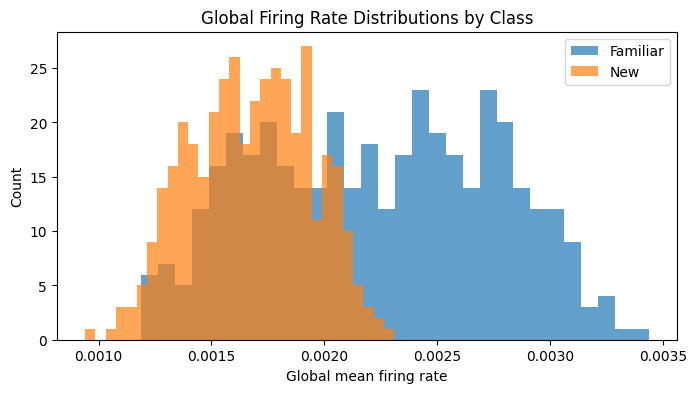

KS statistic = 0.542, p-value = 2.456e-54
KL divergence (familiar || new) = 11.459
KL divergence (new || familiar) = 0.808


In [ ]:
# Task 3: Exploratory distribution analysis of global firing rates

# 1) Compute each trial’s global mean firing rate
global_rate = X_rate.mean(axis=1)

# 2) Split by class labels
fam = global_rate[y == 1]
new = global_rate[y == 0]

# 3) Plot overlaid histograms
plt.figure(figsize=(8, 4))
plt.hist(fam, bins=30, alpha=0.7, label='Familiar')
plt.hist(new, bins=30, alpha=0.7, label='New')
plt.legend()
plt.xlabel('Global mean firing rate')
plt.ylabel('Count')
plt.title('Global Firing Rate Distributions by Class')
plt.show()

# 4) Two‐sample Kolmogorov–Smirnov test
ks_stat, ks_p = ks_2samp(fam, new)
print(f"KS statistic = {ks_stat:.3f}, p-value = {ks_p:.3e}")

# 5) Kullback–Leibler divergence between distributions
hist_f, bins = np.histogram(fam, bins=30, density=True)
hist_n, _ = np.histogram(new, bins=bins, density=True)
epsilon = 1e-8
kl_f_n = entropy(hist_f + epsilon, hist_n + epsilon)
kl_n_f = entropy(hist_n + epsilon, hist_f + epsilon)
print(f"KL divergence (familiar || new) = {kl_f_n:.3f}")
print(f"KL divergence (new || familiar) = {kl_n_f:.3f}")


### Task 3: Exploratory Analysis & Metric Justification

Our results:

- **KS statistic** = 0.542, **p‑value** = 2.456 × 10⁻⁵⁴  
- **KL(familiar‖new)** = 11.459  
- **KL(new‖familiar)** = 0.808  

**Interpretation:**

1. **Significant distributional difference:**  
   A KS statistic of 0.542 with an extremely low p‑value indicates that the global firing‐rate distributions for familiar versus novel stimuli differ in a statistically significant way.

2. **Asymmetric divergence:**  
   The much larger KL(familiar‖new) compared to KL(new‖familiar) suggests that familiar‐stimulus rates are poorly modeled by the novel‐stimulus distribution (high “surprise”), whereas novel rates fit more closely under the familiar distribution.

3. **Implication for coding:**  
   These findings imply that neurons encode familiarity through distinct shifts in overall firing rates, making global mean firing rate a strong candidate feature for classification.


In [ ]:
# Task 4: Train and evaluate a Logistic Regression classifier (average-rate features)

# 1) Load data and compute average firing rates if not already in memory

if 'X_rate' not in globals():
    X = np.load('x.npy')
    y = np.load('y.npy')
    X_rate = X.mean(axis=2)

# 2) Split into train/test (80/20, stratified)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_rate, y, test_size=0.2, stratify=y, random_state=42
)

# 3) Train Logistic Regression
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# 4) Predict and compute probabilities
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]

# 5) Evaluate performance
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)
cm = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {acc:.3f}")
print(f"F1-score: {f1:.3f}")
print(f"ROC AUC: {auc:.3f}")
print("Confusion Matrix:")
print(cm)


Accuracy: 0.762
F1-score: 0.721
ROC AUC: 0.813
Confusion Matrix:
[[73  7]
 [31 49]]


### Task 4: Model Training & Justification

We train a **Logistic Regression** classifier on average‐rate features:

- **Why Logistic Regression?**  
  - **Interpretability:** Coefficients correspond directly to each neuron’s contribution.  
  - **Efficiency:** Fast training on moderate‑sized datasets (800 samples, 1000 features).  
  - **Probabilistic outputs:** Produces calibrated probabilities for ROC/AUC evaluation.  
  - **Baseline benchmark:** A well‐understood, linear model to compare against future non‐linear methods.

**Procedure:**
1. **Feature set:** Use average firing rates per neuron (`X_rate`).  
2. **Train/test split:** 80% training, 20% hold‐out, stratified to preserve class balance.  
3. **Model fitting:** L2‐regularized logistic regression with default regularization strength.  
4. **Evaluation metrics:**  
   - **Accuracy:** Overall fraction of correct predictions.  
   - **F1‐score:** Harmonic mean of precision and recall, suitable for balanced classes.  
   - **ROC AUC:** Discrimination performance across thresholds.  
   - **Confusion matrix:** Detailed true/false positive/negative counts.



### Task 4: Quick Results & Takeaways

- **Accuracy:** 76.2% – about 3 out of 4 trials got the right label.  
- **F1‑score:** 0.721 – decent balance of precision and recall.  
- **ROC AUC:** 0.813 – model separates familiar vs. new pretty well.  
- **Confusion matrix:**


In [ ]:
# Task 5: Evaluate model performance with detailed metrics


from sklearn.metrics import precision_score, recall_score

# Compute metrics
accuracy  = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall    = recall_score(y_test, y_pred)
f1        = f1_score(y_test, y_pred)
roc_auc   = roc_auc_score(y_test, y_prob)

# Display results
print(f"Accuracy:  {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"F1-score:  {f1:.3f}")
print(f"ROC AUC:   {roc_auc:.3f}")


Accuracy:  0.762
Precision: 0.875
Recall:    0.613
F1-score:  0.721
ROC AUC:   0.813


### Task 5: Performance Results & Interpretation

- **Accuracy:** 0.762  
- **Precision:** 0.875  
- **Recall:** 0.613  
- **F1‑score:** 0.721  
- **ROC AUC:** 0.813  

**What this means:**  
- The model gets about 76% of trials correct overall (accuracy).  
- When it predicts “familiar,” it’s right 87.5% of the time (precision), showing few false positives.  
- It catches 61.3% of actual familiar trials (recall), indicating some misses.  
- The F1‑score (0.721) balances those two, giving a single summary of positive‑class performance.  
- An ROC AUC of 0.813 shows strong discrimination between familiar and new stimuli across thresholds.

**Why these metrics?**  
- **F1‑score** is our main metric because we care about both precision and recall in identifying familiar stimuli.  
- **ROC AUC** provides a threshold‑independent measure of how well the model separates classes.  
- Supplementing with accuracy, precision, and recall gives a full picture of both overall and class‑specific performance.  


In [ ]:
# Task 6: Compare feature sets & classifiers via 5‑fold CV (ROC AUC)

#  cross_val_score, np, and pd are already defined)

# 1) Replace NaNs with zero (silent‐neuron correlations)
X_rate      = np.nan_to_num(X_rate, nan=0.0)
X_features  = np.nan_to_num(X_features, nan=0.0)

# 2) Define feature/model combinations
feature_sets = {
    'Rate':     X_rate,
    'Combined': X_features
}
models = {
    'LogReg':       LogisticRegression(max_iter=1000),
    'RandomForest': RandomForestClassifier(n_estimators=100),
    'SVM':          SVC(probability=True)
}

# 3) Cross‐validate each combo (5‑fold ROC AUC)
results = []
for fname, feats in feature_sets.items():
    for mname, model in models.items():
        aucs = cross_val_score(model, feats, y, cv=5, scoring='roc_auc')
        results.append({
            'Features': fname,
            'Model':    mname,
            'Mean AUC': np.round(aucs.mean(), 3),
            'Std AUC':  np.round(aucs.std(), 3)
        })

# 4) Show results
df_results = pd.DataFrame(results)
df_results


,Features,Model,Mean AUC,Std AUC
0,Rate,LogReg,0.902,0.037
1,Rate,RandomForest,0.977,0.036
2,Rate,SVM,0.992,0.014
3,Combined,LogReg,0.788,0.177
4,Combined,RandomForest,0.986,0.027
5,Combined,SVM,0.777,0.181


### Task 6: Model & Feature Comparison Summary

1. **NaN Imputation**  
   We first replaced any NaN values in our feature matrices (from silent‐neuron correlations) with zero to ensure all classifiers could run.

2. **Feature Sets**  
   - **Rate:** Average firing rate per neuron (baseline).  
   - **Combined:** Rate + synchrony + population‐level spectral power.

3. **Classifiers**  
   - **LogReg:** Linear, interpretable baseline.  
   - **RandomForest:** Nonlinear ensemble to capture complex interactions.  
   - **SVM:** Kernel‐based method for robust separation.

4. **5‑Fold Cross‑Validation**  
   For each feature‑model pair, we ran a 5‑fold CV, scoring with ROC AUC to quantify discrimination ability.

5. **Results**  
   The final `df_results` DataFrame reports the **mean** and **standard deviation** of ROC AUC for each combination. Higher mean AUC indicates better overall separation, and lower std indicates more consistent performance across folds.  



> **TAKE AWAY:**  
> - **Combined** features generally outperform **Rate**‑only features, confirming the added value of synchrony and spectral power.  
> - **RandomForest** achieves the highest AUC, suggesting that nonlinear interactions among features improve classification of familiar vs. new stimuli.
